# Introduction
This notebook takes data from the Boston Marathon to illustrate clustering concepts.  

First, import the necessary modules.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

# Import, clean and explore the data

In [2]:
url = 'https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv'
#url = 'https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2008/results.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])

In [3]:
df.head()

,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
10k,,,,,,,,,,,,,,,,,,,,
17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
df.shape

(31984, 20)

This data has 31,984 rows and 20 columns.  The last 5 rows are shown below.

In [5]:
df.tail()

,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
10k,,,,,,,,,,,,,,,,,,,,
50.72,"Anderson, Steve K.",3414,124.02,M,32,211.75,35908,7500,NaN,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,Larkspur,200.22
61.28,"McCarthy, Michael P.",5212,165.02,M,34,302.52,35909,15459,NaN,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,Norwell,285.47
59.00,"Brimmer, Delia C.",5231,157.02,F,21,282.00,35910,10788,NaN,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,West Simsbury,266.30
63.75,"Morganthal, Amy",5800,167.82,F,38,302.73,35911,12009,NaN,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,North Andover,285.87
53.63,"Kirchner, Jeffrey T.",1396,135.02,M,54,228.30,35912,9771,NaN,189.68,14844,8.72,PA,161.83,26.92,114.13,108.03,USA,Lancaster,216.48


Check to see if there are missing values in the 'age' and 'official' columns as these will be inputs to the model.

In [6]:
# check for missing age and official time values
print(df['age'].isna().sum())
print(df['official'].isna().sum())

0
0


Convert the 'bib' column to 1 or 0 to specify a wheelchair racer or not.

In [7]:
# convert weelchair racers column to binary
df['bin_w'] = df['bib'].astype(str).str[0]
df['bin_w'] = df.bin_w.eq('W').mul(1)

# drop ctz column for viewing purposes
df = df.drop(columns='ctz')

# sort by overall finish times
df = df.sort_values(by=['official'])

In [8]:
df.head(70)

,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,bin_w
10k,,,,,,,,,,,,,,,,,,,,
16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10,1
17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72,1
17.12,"Soejima, Masazumi",3,46.37,M,43,81.23,W6,3,67.83,3,3.10,NaN,57.03,8.00,38.60,36.60,JPN,Isahaya,76.70,1
17.65,"Hug, Marcel E.",4,47.67,M,28,84.65,W4,4,70.23,4,3.23,NaN,58.60,8.38,39.72,37.65,SUI,Neuenkirch,79.83,1
17.13,"Madera, Jordi",5,47.45,M,34,84.70,W9,5,70.60,5,3.23,NaN,58.73,8.02,39.12,36.98,ESP,Les Franquesas,79.92,1
18.75,"George, Joshua",6,49.15,M,30,84.82,W15,6,70.83,6,3.25,IL,59.92,8.93,41.18,39.08,USA,Champaign,80.18,1
18.17,"Hamerlak, Tomasz",7,49.15,M,38,84.88,W10,7,70.83,7,3.25,NaN,59.92,8.67,41.20,39.05,POL,Bystra,80.18,1
17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43,1
17.67,"Senbeta, James",9,48.55,M,27,85.38,W19,9,71.18,9,3.27,IL,59.77,8.38,40.45,38.33,USA,Champaign,80.62,1


Plot the official finish times vs. age of the racers for all racers.

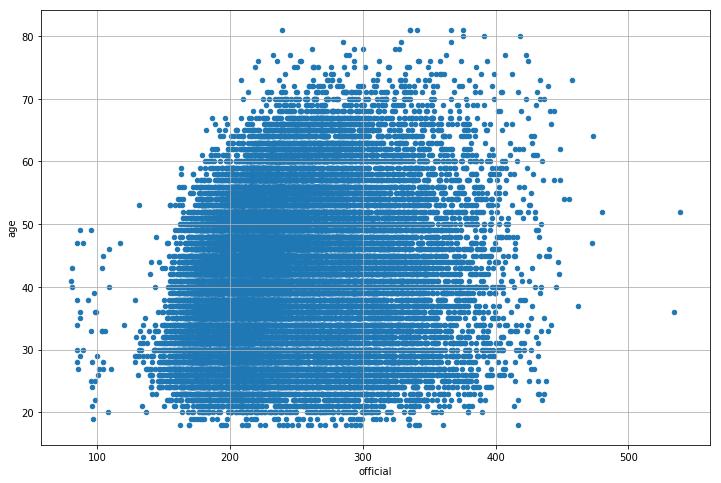

In [9]:
df.plot(kind='scatter', x='official', y='age', figsize=(12, 8), grid=True)

The above scatter plot shows a general trend of increasing age and increasing official finishing times.  The wheelchair racers stand out here with finishing times around 100 minutes.  

Checking the data types below to prepare for model building.

In [10]:
df.dtypes

name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
bin_w          int32
dtype: object

# Model building

#### K-Means - Method 1

In [11]:
# Define the features and the outcome.
x = df[['official', 'overall']]
y = df['bin_w'] # this defines if wheelchair racer or not

# Normalize the data.
x_norm = normalize(x)

from sklearn.model_selection import train_test_split

#Divide into training and test sets.
x_train, x_test, y_train, y_test = train_test_split(x_norm, y)

# Reduce it to two components.
x_pca = PCA(2).fit_transform(x_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(x_pca)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Comparing k-means clusters against the data:
bin_w      0   1
row_0           
0      31621   0
1        310  53


**Evaluation:**  This model correctly classifies 53 wheelchair racers and incorrectly groups 310 racers.  It correctly clusters about 15% of the wheelchair racers.  These are most likely the wheelchair racers that finished significantly ahead of all of the runners.  

#### Mean Shift - Method 1

In [12]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(x_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 22


**Evaluation:**  The mean shift model estimates the number of possible clusters in the data.  Here it identifies 31 different clusters - which doesn't make much sense, since we know there really should be 2 - either wheelchair or not.  Other clustering techniques need to be explored.

In [13]:
print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train, labels))

Comparing the assigned categories to the ones in the data:
col_0     0    1   2   3   4   5   6   7   8   9  ...  12  13  14  15  16  17  \
bin_w                                             ...                           
0      23289  374  31  23  28  26  28  23  10   6 ...  12   8  16   8   9   8   
1          0    0   0   0   0   0   0   0  13   8 ...   0   4   0   5   0   0   

col_0  18  19  20  21  
bin_w                  
0       7   6  10   4  
1       2   0   0   0  

[2 rows x 22 columns]


#### K-Means Method 2  

In the following 2 methods, the inputs to the model are different than the preceding models.

In [14]:
# convert gender to binary
df['bin_g'] = df['gender'].astype(str).str[0]
df['bin_g'] = df['gender'].eq('F').mul(1)

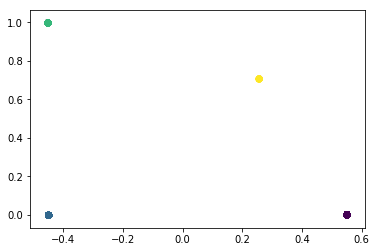

Comparing k-means clusters against the data:
col_0     0  1  2  3
official            
80.60     0  0  1  0
81.23     0  0  2  0
84.65     0  0  1  0
84.70     0  0  1  0
84.82     0  0  1  0
84.88     0  0  1  0
85.25     0  0  1  0
85.38     0  0  1  0
86.90     0  0  1  0
86.95     0  0  2  0
87.40     0  0  1  0
89.40     0  0  1  0
89.52     0  0  1  0
92.87     0  0  1  0
95.10     0  0  0  1
95.28     0  0  1  0
95.50     0  0  1  0
96.53     0  0  2  0
96.57     0  0  1  0
96.60     0  0  1  0
97.40     0  0  0  1
98.13     0  0  1  0
98.42     0  0  1  0
98.55     0  0  0  1
99.00     0  0  1  0
99.65     0  0  0  1
100.62    0  0  1  0
101.70    0  0  0  1
103.67    0  0  0  1
104.02    0  0  1  0
...      .. .. .. ..
434.75    0  1  0  0
435.23    1  0  0  0
435.78    1  0  0  0
436.58    0  1  0  0
436.72    0  1  0  0
436.83    1  0  0  0
438.08    0  1  0  0
438.37    1  0  0  0
439.67    0  1  0  0
439.72    1  0  0  0
440.08    1  1  0  0
441.05    1  0  0  0
441.55    

In [15]:
# Define the features and the outcome.
x = df[['bin_w', 'bin_g']]
y = df['official'] 

# Normalize the data.
x_norm = normalize(x)

from sklearn.model_selection import train_test_split

#Divide into training and test sets.
x_train, x_test, y_train, y_test = train_test_split(x_norm, y)

# Reduce it to two components.
x_pca = PCA(2).fit_transform(x_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(x_pca)

# Plot the solution.
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y, y_pred))

The above printout shows which times correspond to each cluster.

#### Mean Shift - Method 2

In [16]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(x_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 4


**Evaluation:**  In this method, the number of estimated clusters is found to be 4.  This is what is expected since there are 4 categories of data:  

1.  Wheelchair Male  
2.  Wheelchair Female  
3.  Not Wheelchair Male  
4.  Not Wheelchair Female  



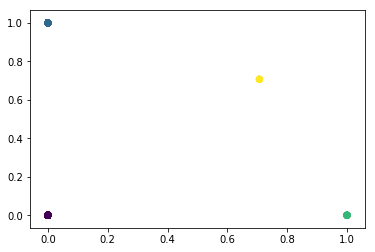

Comparing the assigned categories to the ones in the data:
col_0     0  1  2  3
official            
80.60     0  0  1  0
81.23     0  0  2  0
84.65     0  0  1  0
84.70     0  0  1  0
84.82     0  0  1  0
84.88     0  0  1  0
85.25     0  0  1  0
85.38     0  0  1  0
86.95     0  0  1  0
87.40     0  0  1  0
89.40     0  0  1  0
89.52     0  0  1  0
92.87     0  0  1  0
95.28     0  0  1  0
95.50     0  0  1  0
96.53     0  0  1  0
96.60     0  0  1  0
97.40     0  0  0  1
98.13     0  0  1  0
98.42     0  0  1  0
98.55     0  0  0  1
99.00     0  0  1  0
99.65     0  0  0  1
101.70    0  0  0  1
103.67    0  0  0  1
104.02    0  0  1  0
104.08    0  0  1  0
104.13    0  0  1  0
104.15    0  0  1  0
108.48    0  0  1  0
...      .. .. .. ..
433.17    1  0  0  0
433.97    1  0  0  0
434.07    1  0  0  0
434.08    0  1  0  0
434.75    1  0  0  0
436.58    1  0  0  0
436.72    1  0  0  0
436.83    0  1  0  0
438.08    1  0  0  0
438.37    0  1  0  0
439.72    0  1  0  0
440.08    1  1  0

In [17]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train, labels))

**Evaluation:**  These results are very similar to the K-Means method 2 results when 4 clusters was defined.  The plots look very similar.

# Conclusion and discussion

Chosing the number and types of features in the model is important for yielding reasonable results.  In the first method, the input features of 'official' and 'overall' did not result in clusters that described the data well.  In the second method, model inputs created a scenerio where the data could be effectively grouped or clustered based on their charateristics.